In [ ]:
!git clone https://github.com/KHOATIEU123/demo.git


Cloning into 'demo'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 0), reused 18 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 4.87 MiB | 18.55 MiB/s, done.


In [ ]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
metadata_file = "demo/data.csv"
df = pd.read_csv(metadata_file)

audio_folder = "demo/audio"
target_sr = 44100
max_length = 10
shift_range = 0.2
num_time_masks = 2
num_freq_masks = 2
max_time_mask_length = 50
max_freq_mask_length = 10

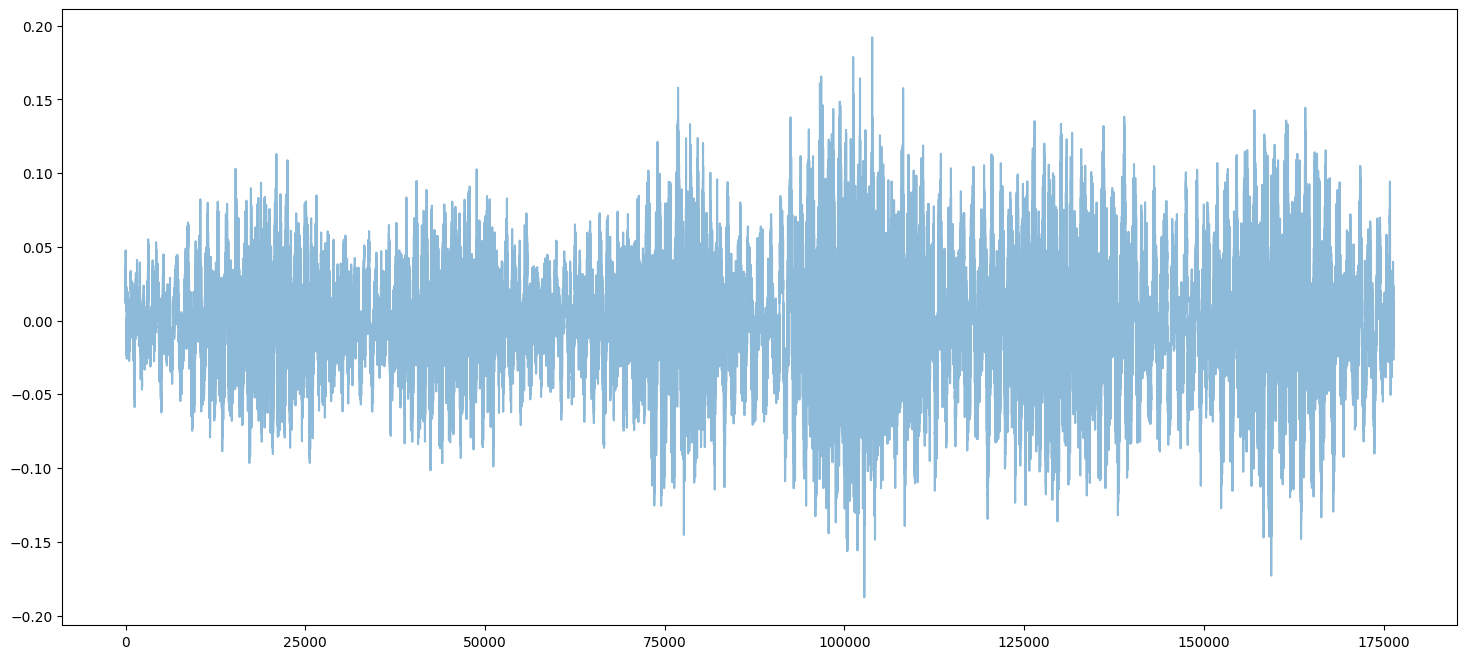

In [ ]:
# plot waveform
plt.figure(figsize=(18, 8))
signal, sr = librosa.load(audio_path, sr=None)
plt.plot(signal, alpha=0.5)
plt.show()

In [ ]:
# Listen audio

from IPython.display import Audio
Audio(audio_path)

In [21]:
class AudioUtil():
   # ----------------------------
   # Load an audio file. Return the signal as a tensor and the sample rate
   # ----------------------------
   @staticmethod
   def open(audio_file):
      sig, sr = torchaudio.load(audio_file)
      return (sig, sr)

In [22]:
def rechannel(aud, new_channel):
   sig, sr = aud

   if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

   if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
   else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

   return ((resig, sr))

In [23]:
@staticmethod
def resample(aud, newsr):
   sig, sr = aud

   if (sr == newsr):
      # Nothing to do
      return aud

   num_channels = sig.shape[0]
   # Resample first channel
   resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
   if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

   return ((resig, newsr))

In [24]:
@staticmethod
def pad_trunc(aud, max_ms):
   sig, sr = aud
   num_rows, sig_len = sig.shape
   max_len = sr//1000 * max_ms

   if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

   elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

   return (sig, sr)

In [25]:
@staticmethod
def time_shift(aud, shift_limit):
   sig,sr = aud
   _, sig_len = sig.shape
   shift_amt = int(random.random() * shift_limit * sig_len)
   return (sig.roll(shift_amt), sr)

In [26]:
@staticmethod
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
   sig,sr = aud
   top_db = 80

   # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
   spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

   # Convert to decibels
   spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
   return (spec)

In [27]:
@staticmethod
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
   _, n_mels, n_steps = spec.shape
   mask_value = spec.mean()
   aug_spec = spec

   freq_mask_param = max_mask_pct * n_mels
   for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

   time_mask_param = max_mask_pct * n_steps
   for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

   return aug_spec

In [28]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
   def __init__(self, df, data_path):
      self.df = df
      self.data_path = str(data_path)
      self.duration = 4000
      self.sr = 44100
      self.channel = 2
      self.shift_pct = 0.4

   # ----------------------------
   # Number of items in dataset
   # ----------------------------
   def __len__(self):
      return len(self.df)

   # ----------------------------
   # Get i'th item in dataset
   # ----------------------------
   def __getitem__(self, idx):
      # Absolute file path of the audio file - concatenate the audio directory with
      # the relative path
      audio_file = self.data_path + self.df.loc[idx, 'relative_path']
      # Get the Class ID
      class_id = self.df.loc[idx, 'classID']

      aud = AudioUtil.open(audio_file)
      # Some sounds have a higher sample rate, or fewer channels compared to the
      # majority. So make all sounds have the same number of channels and same
      # sample rate. Unless the sample rate is the same, the pad_trunc will still
      # result in arrays of different lengths, even though the sound duration is
      # the same.
      reaud = AudioUtil.resample(aud, self.sr)
      rechan = AudioUtil.rechannel(reaud, self.channel)

      dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
      shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
      sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
      aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

      return aug_sgram, class_id

In [ ]:
def spec_augment(mel_spec, num_time_masks, num_freq_masks, max_time_mask_length, max_freq_mask_length):
    augmented_spec = mel_spec.copy()
    num_bins, num_frames = augmented_spec.shape
    for _ in range(num_time_masks):
        mask_length = random.randint(0, max_time_mask_length)
        mask_start = random.randint(0, num_frames - mask_length)
        augmented_spec[:, mask_start:mask_start + mask_length] = 0
    for _ in range(num_freq_masks):
        mask_length = random.randint(0, max_freq_mask_length)
        mask_start = random.randint(0, num_bins - mask_length)
        augmented_spec[mask_start:mask_start + mask_length, :] = 0

    return augmented_spec

In [29]:
batch_size = 32
num_batches = (len(df) - 1) // batch_size + 1

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(df))

    audio_paths = audio_folder + '/' + df['slice_file_name'].values[start_idx:end_idx]


In [30]:
for audio_path in audio_paths:
        audio, sr = librosa.load(audio_path, sr=None)
        if audio.ndim > 1:
            audio = librosa.core.to_mono(audio)
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        target_length = int(max_length * target_sr)

        if len(audio) < target_length:
            shortage = target_length - len(audio)
            silence = np.zeros(shortage)
            audio = np.concatenate((audio, silence))
        elif len(audio) > target_length:
            audio = audio[:target_length]

        shift_amount = int(shift_range * target_sr)
        shift_direction = np.random.choice([-1, 1])
        audio_shifted = np.roll(audio, shift_amount * shift_direction)
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=target_sr, n_fft=2048, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        augmented_spec = spec_augment(log_mel_spec, num_time_masks, num_freq_masks, max_time_mask_length, max_freq_mask_length)

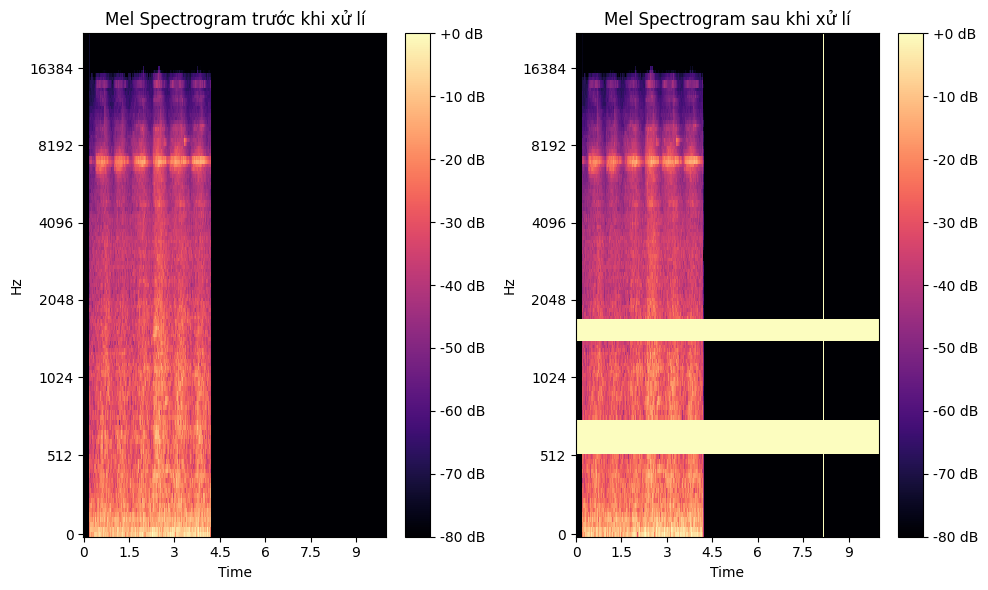

In [31]:
plt.figure(num='Khoa Tiêu -' + audio_path, figsize=(10, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(log_mel_spec, sr=target_sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram trước khi xử lí')
plt.subplot(1, 2, 2)
librosa.display.specshow(augmented_spec, sr=target_sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram sau khi xử lí')
plt.tight_layout()
plt.show()

In [32]:
print(type(log_mel_spec), log_mel_spec.shape)

<class 'numpy.ndarray'> (128, 862)
